In [1]:
import sys
import os
sys.path.append('..')
from lib.path import get_training_data_dir, get_predicted_labeled_water_path, get_displaceable_water_path, get_non_displaceable_water_path
from lib.pdb import filter_atoms_and_create_new_pdb
from data_loader.SingleDataLoader import SingleDataLoader
from data_loader.DoubleDataLoader import DoubleDataLoader
from models.LeNet import LeNet
from models.ResNet import ResNet
from models.ResNet_revised import ResNet_revised
from lib.helper import get_latest_checkpoint
from tensorflow.keras.losses import BinaryCrossentropy
from custom_losses.dice import dice_loss, dice_coefficient
from tensorflow.keras.metrics import Recall, Precision, Accuracy, SpecificityAtSensitivity, AUC, F1Score
from sklearn.metrics import fbeta_score, confusion_matrix
import numpy as np

2024-08-05 09:25:56.671993: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-05 09:25:56.685033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 09:25:56.699235: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 09:25:56.703460: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-05 09:25:56.714404: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import tensorflow as tf

# GPUを無効化
tf.config.set_visible_devices([], 'GPU')

In [3]:
DATA_TYPE1 = 'gr'
# DATA_TYPE2 = 'Protein'
DATA_VOXEL_NUM = 10
CLASSIFYING_RULE = 'WaterClassifyingRuleEmbedding'
LIGAND_POCKET_DEFINER = 'LigandPocketDefinerOriginal'
LIGAND_VOXEL_NUM = 8
MODEL_NAME = 'ResNet'
TRAINER_NAME = 'aug_train'
training_data_dir1 = get_training_data_dir(DATA_TYPE1, DATA_VOXEL_NUM, CLASSIFYING_RULE, LIGAND_POCKET_DEFINER, LIGAND_VOXEL_NUM)
# training_data_dir2 = get_training_data_dir(DATA_TYPE2, DATA_VOXEL_NUM, CLASSIFYING_RULE, LIGAND_POCKET_DEFINER, LIGAND_VOXEL_NUM)

data_dir = '../../data'
test_list = os.path.join(data_dir, 'test.txt')
data_loader = SingleDataLoader(training_data_dir1)
# data_loader = DoubleDataLoader(training_data_dir1, training_data_dir2)
test_data, test_data_label = data_loader.load_data(test_list)
print(test_data.shape)

(13354, 21, 21, 21, 1)


In [4]:
input_shape = (DATA_VOXEL_NUM*2+1, DATA_VOXEL_NUM*2+1, DATA_VOXEL_NUM*2+1, test_data.shape[-1])
n_base = 8
BN = True

In [5]:
checkpoint_dir = f'../checkpoints/{DATA_TYPE1}/data_voxel_num_{DATA_VOXEL_NUM}/{LIGAND_POCKET_DEFINER}/ligand_pocket_voxel_num_{LIGAND_VOXEL_NUM}/{CLASSIFYING_RULE}/{MODEL_NAME}/{TRAINER_NAME}/'
# checkpoint_dir = f'../checkpoints/{DATA_TYPE1}_{DATA_TYPE2}/data_voxel_num_{DATA_VOXEL_NUM}/{LIGAND_POCKET_DEFINER}/ligand_pocket_voxel_num_{LIGAND_VOXEL_NUM}/{CLASSIFYING_RULE}/{MODEL_NAME}/{TRAINER_NAME}/'
latest_checkpoint = get_latest_checkpoint(checkpoint_dir)
model = ResNet(n_base=n_base, input_shape=input_shape, learning_rate=0.0, loss=BinaryCrossentropy(), metrics=[], BN=BN)
model.load_weights(latest_checkpoint)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 21, 21,    │          0 │ -                 │
│ (InputLayer)        │ 21, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 21, 21,    │        224 │ input_layer[0][0] │
│                     │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 21, 21,    │         32 │ conv3d[0][0]      │
│ (BatchNormalizatio… │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 21, 21,    │          0 │ batch_normalizat… │
│ (Activation)        │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 21, 21,    │      1,736 │ activation[0][0]  │
│                     │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 21,    │         32 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 21, 21,    │          0 │ batch_normalizat… │
│ (Activation)        │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 21, 21,    │      1,736 │ activation_1[0][… │
│                     │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 21,    │         32 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 21, 21,    │          0 │ batch_normalizat… │
│                     │ 21, 8)            │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 21, 21,    │          0 │ add[0][0]         │
│ (Activation)        │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 10, 10,    │          0 │ activation_2[0][… │
│ (MaxPooling3D)      │ 10, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 10, 10,    │      3,472 │ max_pooling3d[0]… │
│                     │ 10, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │         64 │ conv3d_3[0][0]    │
│ (BatchNormalizatio… │ 10, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 10, 10,    │          0 │ batch_normalizat… │
│ (Activation)        │ 10, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 10, 10,    │      6,928 │ activation_3[0][… │
│                     │ 10, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 10, 10,    │        144 │ max_pooling3d[0]

 Total params: 58,081 (226.88 KB)

 Trainable params: 57,745 (225.57 KB)

 Non-trainable params: 336 (1.31 KB)

/home/ito/research/src/yuki_research/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 82 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [6]:
prediction = model.predict(test_data)
prediction_values = prediction.reshape(prediction.shape[0])
predicted_label = prediction.round()


I0000 00:00:1722817561.296836 1495153 service.cc:146] XLA service 0x14fe10011770 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722817561.296885 1495153 service.cc:154]   StreamExecutor device (0): Host, Default Version
2024-08-05 09:26:01.308209: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1722817561.478002 1495153 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


418/418 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step


In [7]:
predicted_label.shape

(13354, 1)

In [8]:
test_data_label[6],predicted_label[6]

(1.0, array([1.], dtype=float32))

In [9]:
cm1 = confusion_matrix(test_data_label, predicted_label)

# 混同行列の要素を取り出す
tn, fp, fn, tp = cm1.ravel()

# 結果を表示
print("Confusion Matrix:")
print(cm1)
print(f"True Negative (TN): {tn}")
print(f"False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}")
print(f"True Positive (TP): {tp}")
negative_precision = tn / (tn + fn)
print(negative_precision)

Confusion Matrix:
[[4660 1882]
 [1781 5031]]
True Negative (TN): 4660
False Positive (FP): 1882
False Negative (FN): 1781
True Positive (TP): 5031
0.7234901412824095


In [10]:
# 混合行列のそれぞれの要素の正解データのラベルの配列を取得する（どのテストデータがどのように予測されているかを確認するため）
tn_index = []
fp_index = []
fn_index = []
tp_index = []

for i, (true_label, pred_label) in enumerate(zip(test_data_label, predicted_label)):
    if true_label == 0 and pred_label == 0:
        tn_index.append(i)
    elif true_label == 0 and pred_label == 1:
        fp_index.append(i)
    elif true_label == 1 and pred_label == 0:
        fn_index.append(i)
    elif true_label == 1 and pred_label == 1:
        tp_index.append(i)

In [11]:
recall = Recall()
recall.update_state(test_data_label, predicted_label)
recall_value = recall.result().numpy()

precision = Precision()
precision.update_state(test_data_label, predicted_label)
precision_value = precision.result().numpy()

accuracy = Accuracy()
accuracy.update_state(test_data_label, predicted_label)
accuracy_value = accuracy.result().numpy()

specificity = SpecificityAtSensitivity(recall_value)
specificity.update_state(test_data_label, predicted_label)
specificity_value = specificity.result().numpy()

auc = AUC()
auc.update_state(test_data_label, prediction_values)
auc_value = auc.result().numpy()

In [12]:
print({"recall": recall_value, "precision": precision_value, "accuracy": accuracy_value, "specificity": specificity_value, "dice_coefficient": dice_coefficient(test_data_label, predicted_label).numpy(), "auc": auc_value})

{'recall': 0.7385496, 'precision': 0.7277593, 'accuracy': 0.72570014, 'specificity': 0.7123204, 'dice_coefficient': 0.7331342, 'auc': 0.7938146}


In [36]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(test_data_label, prediction_values)

In [37]:
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold_youden = thresholds[optimal_idx]
optimal_threshold_youden

0.47551808

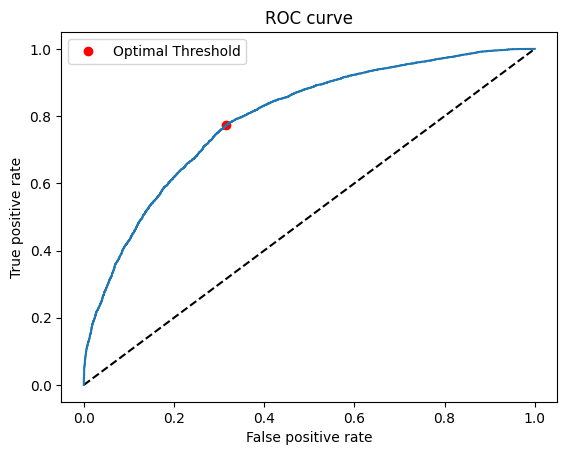

In [38]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', label='Optimal Threshold')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [39]:
np.where(tpr > 0.70)[0]


array([2354, 2355, 2356, ..., 4955, 4956, 4957])

In [40]:
tpr[2356]
# thresholds[2748]

0.700381679389313

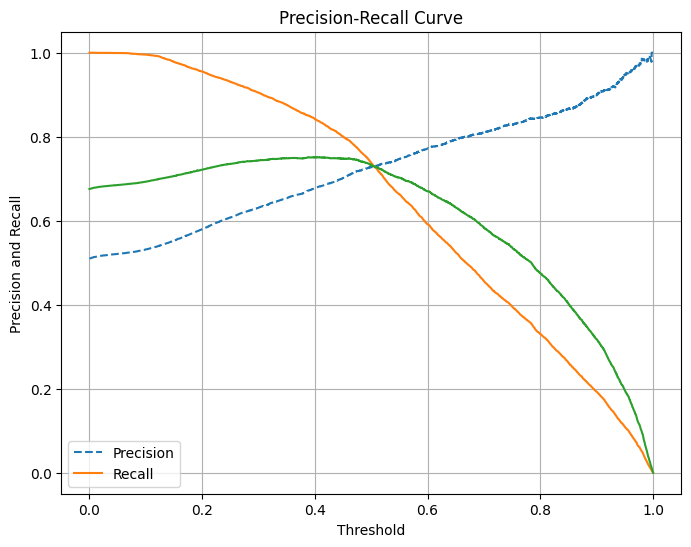

0.40898278
0.8364650616559014 0.6819868342309994


In [41]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall曲線の計算
precisions, recalls, thresholds = precision_recall_curve(test_data_label, prediction_values)
f1 = 2 * precisions * recalls / (precisions + recalls)
# Precision-Recall曲線の描画
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label="Precision", linestyle='--')
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.plot(thresholds, f1[:-1])
plt.xlabel("Threshold")
plt.ylabel("Precision and Recall")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()
print(thresholds[np.argmax(f1)])
print(recalls[np.argmax(f1)], precisions[np.argmax(f1)])

# # 最適な閾値の選定（ここではrecallがある一定以上の場合の閾値を選ぶ例）
# target_recall = 0.8  # 目標とするrecall値
# optimal_threshold = 0.5  # 初期値

# for precision, recall, threshold in zip(precisions, recalls, thresholds):
#     if recall >= target_recall:
#         optimal_threshold = threshold
#         break

# print(f"Optimal threshold for target recall {target_recall}: {optimal_threshold}")


In [42]:
def custom_threshold(prediction, threshold):
    return (prediction > threshold).astype(int)
optimal_threshold_youden = 0.45
optimal_predicted_label = custom_threshold(prediction_values, optimal_threshold_youden)

In [43]:
recall = Recall()
recall.update_state(test_data_label, optimal_predicted_label)
optimal_recall_value = recall.result().numpy()

precision = Precision()
precision.update_state(test_data_label, optimal_predicted_label)
optimal_precision_value = precision.result().numpy()

accuracy = Accuracy()
accuracy.update_state(test_data_label, optimal_predicted_label)
optimal_accuracy_value = accuracy.result().numpy()

specificity = SpecificityAtSensitivity(optimal_recall_value)
specificity.update_state(test_data_label, optimal_predicted_label)
optimal_specificity_value = specificity.result().numpy()

f2 = fbeta_score(test_data_label, optimal_predicted_label, beta=1)


auc = AUC()
auc.update_state(test_data_label, prediction_values)
auc_value = auc.result().numpy()


In [44]:
f2

0.7479095270733379

In [45]:
cm2 = confusion_matrix(test_data_label, optimal_predicted_label)

# 混同行列の要素を取り出す
tn, fp, fn, tp = cm2.ravel()

# 結果を表示
print("Confusion Matrix:")
print(cm2)
print(f"True Negative (TN): {tn}")
print(f"False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}")
print(f"True Positive (TP): {tp}")
negative_precision = tn / (tn + fn)
print(negative_precision)

Confusion Matrix:
[[4220 2322]
 [1356 5456]]
True Negative (TN): 4220
False Positive (FP): 2322
False Negative (FN): 1356
True Positive (TP): 5456
0.7568149210903874


In [46]:
print({"recall": optimal_recall_value, "precision": optimal_precision_value, "accuracy": optimal_accuracy_value, "specificity": optimal_specificity_value, "dice_coefficient": dice_coefficient(test_data_label, optimal_predicted_label).numpy(),"f2": f2, "auc": auc_value})

{'recall': 0.8009395, 'precision': 0.70146567, 'accuracy': 0.7245769, 'specificity': 0.6450627, 'dice_coefficient': 0.74792683, 'f2': 0.7479095270733379, 'auc': 0.7938146}


In [47]:
def calculate_metrics(confusion_matrix1, confusion_matrix2):
    # Sum the confusion matrices
    total_confusion_matrix = confusion_matrix1 + confusion_matrix2

    # Extract values
    TN = total_confusion_matrix[0, 0]
    FP = total_confusion_matrix[0, 1]
    FN = total_confusion_matrix[1, 0]
    TP = total_confusion_matrix[1, 1]

    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    specificity = TN / (TN + FP)
    dice_coefficient = 2 * TP / (2 * TP + FP + FN)
    auc = (recall + specificity) / 2

    # Store metrics in a dictionary
    metrics = {
        'recall': recall,
        'precision': precision,
        'accuracy': accuracy,
        'specificity': specificity,
        'dice_coefficient': dice_coefficient,
        'auc': auc
    }

    return metrics

In [48]:
cm1 = [[1884,  504],
 [ 814 ,1779]]

cm1 = np.array([[1706, 682],
 [ 655, 1938]])

cm2 = np.array([[3024, 1085],
 [1196 ,3224]])

In [49]:
cm1 + cm2

array([[4730, 1767],
       [1851, 5162]])

In [50]:
print(calculate_metrics(cm1, cm2))

{'recall': 0.7360615998859261, 'precision': 0.7449848462981671, 'accuracy': 0.7321983715766099, 'specificity': 0.7280283207634293, 'dice_coefficient': 0.740496341988237, 'auc': 0.7320449603246777}
